In [ ]:
#| default_exp TreeClusters

# Cluster Tree

Basic classes to generate a clusters tree structure make a Hierarchical Geo Clustering analisys. 

In [ ]:
#| hide
from nbdev.showdoc import *
import warnings
warnings.simplefilter('ignore')

In [ ]:
#| export
import sklearn
from sklearn import cluster, datasets
import anytree
import random
import numpy as np
import shapely
import pandas as pd
import re
import math
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import polygonize, cascaded_union
from shapely.geometry import box
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import polygonize_full, linemerge, unary_union
from matplotlib import cm
from anytree import NodeMixin, RenderTree


In [ ]:
#| export
def inside_polygon(list_points, poligon_check, min_percent):
    """
    Help function to validate the number of points that are inside the polygon 
    
    :param list list_points: List of points to consider 
    
    :param shapely.geometry.Polygon poligon_check:   
    
    :param min_percent: Minimun percent of point to be consider inside 
    
    :returns tuple: (bool, list of point inside).   
    """
    if len(list_points)< 2:
        return False
    inside = [i for i in list_points if poligon_check.contains(i) ]
    #print(len(inside))
    if len(inside) > int(min_percent*len(list_points)):
        
        return True , inside
    else: 

        return False , inside

In [ ]:
#| hide 
#### test the function
pol_square = shapely.geometry.Polygon(((0., 0.), (0., 1.), (1., 1.), (1., 0.), (0., 0.)))
list_points =[shapely.geometry.Point(0.25, 0.25 ),
              shapely.geometry.Point(0.75, 0.25 ),
              shapely.geometry.Point(0.75,0.75 ),
              shapely.geometry.Point(0.25,0.75 ), 
              shapely.geometry.Point(1.25,1.75 ),
             ]
inside_polygon(list_points, pol_square, .75) ### sould return true and 4 element inside the list


(True,
 [<shapely.geometry.point.Point>,
  <shapely.geometry.point.Point>,
  <shapely.geometry.point.Point>,
  <shapely.geometry.point.Point>])

In [ ]:
#| export
def poligon_non_convex_from_Points( points_li ):
    """
    Create a random (no convex) poligon from the points
    The algorithm returns a polygon creatated from the points, the 
    non convex part it is not always guaranteed.
    
    :param list points_li: list of shapely.geometry.Point 
    
    :returns shapely.grometry.Polygon: The polygon created 
    """
    
    triangles = shapely.ops.triangulate(shapely.geometry.Polygon(points_li))
    Pol = shapely.geometry.Polygon(points_li).convex_hull
    remove_triangles = []
    keep_triangles = []
    for i in triangles:
        inter = Pol.exterior.intersection(i)
        if type(inter) == shapely.geometry.linestring.LineString and inter.length != 0.0:
            remove_triangles.append(i)
        else:
            keep_triangles.append(i)
    return shapely.ops.cascaded_union(keep_triangles)

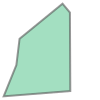

In [ ]:
#| hide
x = [random.uniform(0, 1) for i in range(10)]
y = [random.uniform(0, 1) for i in range(10)]
poligon_non_convex_from_Points([shapely.geometry.Point(l[0], l[1])  for l in  zip(x,y)] )

In [ ]:
#| export 
def poligon_non_convex_random_gen(npoints):
    """
    Create a random (no convex) poligon from n points
    The algorithm returns a polygon creatated from n random 2d points the 
    non convex part it is not always guaranteed.
    
    :param int npoints: Number of point to generate the polygon 
    
    :returns shapely.geometry.Polygon: The polygon created
    """
    points_r = np.random.random((npoints, 2))
    triangles = shapely.ops.triangulate(shapely.geometry.Polygon(points_r))
    Pol = shapely.geometry.Polygon(points_r).convex_hull
    remove_triangles = []
    keep_triangles = []
    for i in triangles:
        inter = Pol.exterior.intersection(i)
        if type(inter) == shapely.geometry.linestring.LineString and inter.length != 0.0:
            remove_triangles.append(i)
        else:
            keep_triangles.append(i)
    return shapely.ops.unary_union(keep_triangles)

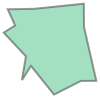

In [ ]:
#| hide
poligon_non_convex_random_gen(20)

In [ ]:
#| hide
#| export
def string_recursive_tag( string_tag, **kwargs):
    """
    params: level_str level string
    params: until_level_str level string finish
    params: node_str node string 
    params: until_node_str node string finish
    params: noise_str nois string
    params: tree_rec tree to obtain the final cluster id
    
    returns level and cluster id from the tag using a tree 
    """
    
    level_str = kwargs.get('level_str', '_L_' )
    until_level_str = kwargs.get('until_level_str', '_l_')
    node_str  = kwargs.get('node_str', '_l_')
    until_node_str = kwargs.get('until_node_str', '_c_')
    noise_str= kwargs.get ('noise_str', '_noise')
    tree = kwargs.get( 'tree_rec', None)
    ### Level
    positions_level = [ i.start() for i in re.finditer( level_str, string_tag )]
    until_level_pos = [ i.start() for i in re.finditer( until_level_str, string_tag )]
    levels = [string_tag[ i + len(level_str):j] for i, j in zip(positions_level, until_level_pos) ]
    ### Node
    nodeid_positions = [i.start() for i in re.finditer( node_str, string_tag )]
    until_node_posicion = [i.start() for i in re.finditer( until_node_str,  string_tag) ]
    nodeid = [string_tag[i+len(node_str):j ] for i,j in zip(nodeid_positions, until_node_posicion)]
    
    
    string_find= string_tag[:string_tag.rfind(noise_str)]
    if len(levels)==1:
        level_f= tree.get_level(int(levels[-1]))
        for j in level_f :
            for num, i in enumerate(j.children):
                if i.name == string_find:
                    nodeid.append(str(num))
    elif len(levels)>=2:
        nodeid = nodeid[1:]
        #print(levels[-2])
        #print(nodeid[-1])
        #print(string_tag)

        for num, i in enumerate(tree.get_node(level_int= int(levels[-2]), node_int=int(nodeid[-1]) ).children) :
            #print(i.name)
            if i.name == string_find:
                nodeid.append(str(num))
    return levels, nodeid

In [ ]:
#| hide
#| export
def retag_from_strings(string_tag) :
    """
    Returns only the final node tag
    """
    valure = string_tag.rfind('+') 
    if  valure!= -1 :
        tag_recal =string_tag [valure+1:]  
    else :
        tag_recal = string_tag
    return tag_recal


In [ ]:
#| hide
#| export 
class cluster(object):
    """
    A Basic class of a cluster 
    """
    polygon_cluster = None
    point_cluster_noise = None

    def __init__(self):
        self.polygon_cluster = None
        self.density = None
        self.point_cluster_noise = None
    

In [ ]:
#| hide
clus=cluster()

## NodeCluster 
The class has all the methods to create and visualize a cluster. 

In [ ]:
#| export 
class NodeCluster(cluster, NodeMixin):
    def __init__(self, 
                name,
                density=None,
                parent=None,
                children=None):
        """
        Constructor of the class
        
        :param str name: Name of the cluster
        
        :param double density: Density of the cluster (Default =None)
        
        :param NodeCluster parent: Cluster parent (Default = None)
        
        :param list children: List of its children (Default =None)
        
        """
        
        super(cluster, self).__init__()
        self.name = name
        self.parent = parent
        self.polygon_cluster = None
        if children:
             self.children = children

    
    def populate_cluster(self,
                    from_points_num=20,
                    density=None,
                    num_points=None,
                    min_scale_x= .1,
                    max_scale_x=.5,
                    min_scale_y= .1,
                    max_scale_y=.5,
                    random_state= 170, 
                    **kwargs
                    ):
        """
        Populate the cluster on random bases 
        
        :param int random_state: Random state 
        
        :param double min_scale_x: min x value range ( Default=.1 )
        
        :param double max_scale_x: max x value range ( Default=.5 )
        
        :param double min_scale_y: min y value range ( Default=.1 )
        
        :param double max_scale_y: max y value range ( Default=.5 )
        """
        self.density = density
        random.seed(random_state) ## initialize random state 
        avoid_intersec= kwargs.get('avoid_intersec', False)
        if self.parent is None:
            self.polygon_cluster = self.create_polygon(from_points_num)
            new_pol_x_min, new_pol_y_min, new_pol_x_max, new_pol_y_max = self.polygon_cluster.bounds
            self.center = shapely.geometry.Point((new_pol_x_max -new_pol_x_min)/2 + new_pol_x_min,
                             (new_pol_y_max- new_pol_y_min)/2+new_pol_y_min)

        else:
            #### create the polygon inside the parent 
            
            if self.parent.polygon_cluster ==None:
                raise ValueError('The parent has no polygon')
            
            # print('parent name:',self.parent.name)
            ########
            #### Vamos a pedirle que no este en el polygono de los hijos 
            random_point_center = self.parent.get_random_points(1, random_state)[0]

            #### create polygon and scale 
            
            polygon = self.create_polygon(from_points_num)
            new_pol_x_min, new_pol_y_min, new_pol_x_max, new_pol_y_max = polygon.bounds
            center_polygon = shapely.geometry.Point((new_pol_x_max -new_pol_x_min)/2 + new_pol_x_min,
                             (new_pol_y_max- new_pol_y_min)/2+new_pol_y_min)
            translate = shapely.geometry.Point(
                            random_point_center.x -center_polygon.x,
                            random_point_center.y -center_polygon.y
                            ) 
            polygon = shapely.affinity.translate( 
                        polygon, 
                        xoff = translate.x,
                        yoff = translate.y
                        )
            new_pol_x_min, new_pol_y_min, new_pol_x_max, new_pol_y_max = polygon.bounds
            esq = [
                shapely.geometry.Point(new_pol_x_min,new_pol_y_min ),
                shapely.geometry.Point(new_pol_x_min,new_pol_y_max ),
                shapely.geometry.Point(new_pol_x_max,new_pol_y_min ),
                shapely.geometry.Point(new_pol_x_max,new_pol_y_max )
              ]
            max_dis_esq = max([random_point_center.distance(i) for i in esq])
            
            ###### Scale the polygon 
            #dis_poly_parent= self.parent.polygon_cluster.exterior.distance(random_point_center)
            
            max_dis = self.parent.polygon_cluster.exterior.distance( random_point_center)

            fact_pol = (max_dis/(1.3*max_dis_esq))
            
            scale_factor_max_x  = min (fact_pol, max_scale_x)
            scale_factor_max_y  = min (fact_pol, max_scale_y)
            # print('scale x:', scale_factor_max_x)
            # print('scale y:', scale_factor_max_y)
            ##########
            polygon= shapely.affinity.scale( 
                polygon,
                xfact=scale_factor_max_x,
                yfact=scale_factor_max_y,
                origin= random_point_center
            )
            
            ###### Aqui se tiene que verificar si ha caido en alguno. 
            if avoid_intersec == False:
                self.polygon_cluster  = polygon
                self.center = random_point_center
            else:
                ### Se tiene que modificar
                self.polygon_cluster, self.center = self.parent.polygon_not_intersec_children(random_state= random_state)
                

        ############### The points
        if self.polygon_cluster is None:
            raise ValueError('No polygon in the cluster')

        if self.density is not None:
            npoints_polygon  = int(self.polygon_cluster.area*density)
            #print(npoints_polygon)
            self.point_cluster_noise = self.create_random_points(npoints_polygon) 
        elif self.density is None and num_points is not None:
            self.density = num_points /self.polygon_cluster.area
            #print(num_points)
            self.point_cluster_noise = self.create_random_points(num_points)
        

    ##### Generate random polygon
    def create_polygon(self,  from_points_num=20):
        """
        Generate a random polygon for the cluster
        
        :param from_points_num: The number of points to 
        generate the cluster from 
        """
        polygon = poligon_non_convex_random_gen(from_points_num)
        while type(polygon) == shapely.geometry.MultiPolygon:
            polygon = poligon_non_convex_random_gen(
                from_points_num)
        return polygon


    def get_random_points(self, n_points, random_state= 150):
        """
        Returns random points inside the cluster polygon
        
        :param n_points Number of point to be generated
        
        :param random_state Random state
        
        :returns: A list with points
        """
        random.seed(random_state)
        x_min, y_min ,x_max, y_max =self.polygon_cluster.bounds
        ret_points= []
        while len(ret_points)< n_points:
            x_rand = random.uniform(x_min, x_max)
            y_rand = random.uniform(y_min, y_max)
            point_s =shapely.geometry.Point(x_rand, y_rand)
            
            if self.polygon_cluster.contains(point_s):
                ret_points.append(point_s)
        

        return ret_points    
    #### create random_points
    def create_random_points(self, 
                             npoints_polygon=1000,
                             random_state = 120):
        """
        Create random points 
        
        :param npoints_polygon Number of point to get
        
        :random_state Random state integer to ste random
        
        :returns: A shapely multyPoint clas witn npoints_polygon points
        
        """
        random.seed(random_state)
        minx_b, miny_b, maxx_b, maxy_b = self.polygon_cluster.bounds
        point_cluster_noise = []
        while len(point_cluster_noise) < npoints_polygon:
            points_cluster = np.random.random_sample(
                (int(npoints_polygon*1.2), 2))
            points_cluster[:, 0] = (maxx_b - minx_b) * \
                points_cluster[:, 0] + minx_b
            points_cluster[:, 1] = (maxy_b - miny_b) * \
                points_cluster[:, 1] + miny_b
            points_cluster = shapely.geometry.MultiPoint(list(points_cluster))
            points_cluster_o = [p for p in points_cluster.geoms if
                                self.polygon_cluster.contains(p)
                                ]
            point_cluster_noise = point_cluster_noise + points_cluster_o

        point_cluster_noise = shapely.geometry.MultiPoint(point_cluster_noise[:npoints_polygon])
        
        return point_cluster_noise




    def scale(self,x_scale, y_scale, center_scale= 'center'):
        """
        Scale the points in the cluster 
        
        :param x_scale Scale factor to scale in x axis
        
        :param y_scale Scale factor to scale in y axis
        
        :param center_scale Scale center point  (Default = 'center')
        
        :returns: No returns
        """
        if self.point_cluster_noise is not None:
            self.point_cluster_noise = shapely.affinity.scale(
                                    self.point_cluster_noise,
                                    xfact=  x_scale,
                                    yfact=  y_scale,
                                    origin = center_scale
                                    )
        if  self.polygon_cluster is not None:
            self.polygon_cluster = shapely.affinity.scale(
                                    self.polygon_cluster,
                                    xfact=  x_scale,
                                    yfact=  y_scale,
                                    origin = center_scale
                                    ) 
        ########Se deberian escalar todos #2 sus nodos hijos
        # 
    
    def get_density(self):
        """
        Get the density of the cluster 
        
        :returns double: The density of the node
        """
        if self.density is not None:
            return self.density
        else:
            if self.polygon_cluster is None:
                print("Cluster has no polygon")
                self.density = None
                return self.density
            else:
                if self.polygon_cluster is not None:
                    if self.point_cluster_noise is None:
                        print('the node has no points')
                        return 0
                    else:
                        self.density = len(self.point_cluster_noise)/self.polygon_cluster.area
                        return self.density

            
            


    ###### Get center
    
    def get_center(self):
        """
        Get the center of the bounding box poligon
        
        :returns: Shapely Point center 
        """
        if self.center is not None:
            return self.center
        else:
            if self.polygon_cluster is None:
                print("Cluster has no polygon")
                return None
            else:
                bou = new.polygon_cluster.bounds
                x=(bou[2]-bou[0])/2
                y=(bou[3]-bou[1])/2
                self.center = shapely.geometry.Point(x,y)
                return self.center
             
    


    ##### Get Points get the noise points of the cluster
    def get_points(self, all_tag = False ):
        """ 
        Returns the noise point of the cluster, if all_tag is set true returns  
        all the points of the its decendents
        """
        if all_tag == False:
            return self.point_cluster_noise
        else :
            all_points = []
            if self.parent is None:
                all_points.append((self.point_cluster_noise, self.name  ))
            else:
                all_points.append((self.point_cluster_noise, self.parent.name + '_' +self.name))
            
            for child in self.children:
                all_points= all_points + child.get_points(all_tag = all_tag)

        return  all_points
    
    def get_point_decendent(self):
        """
        Returns all the point of the node and its decendents
        
        """
        all_p  = []
        all_p= all_p+ [i for i in self.get_points()]
        for child in self.children:
            all_p= all_p +child.get_point_decendent()
        return all_p


    ######Tag the points 
    def tag_low_level(self, point_check= None):
        """
        The tag the element of the node using the labels noise or the child name
        as a tag, if a set of point is pass (point_check != None)  
        the elements are treated as part of the cluster and label it accordingly. 
        :params self 
        :params point_check A list MultiPoint or list with Points to tag 
        """        
        
        if point_check is None:
            all_points_cluster = self.get_points()
        else:
            #all_points_cluster = self.get_points()
            all_points_cluster = point_check
        # print('Leng to check:', len(all_points_cluster))
        all_point_tag = []
        for point in all_points_cluster:
            point_tag= ''
            for id_child, child in enumerate(self.children):
                if child.polygon_cluster.contains(point):
                    if child.name is None:
                        point_tag = point_tag+str(id_child)
                    else:
                        if point_tag== '':
                            point_tag = child.name
                        else:
                            point_tag = point_tag +'_'+ child.name 
                
            if point_tag=='':
                    point_tag = self.name+'_'+'noise'
            all_point_tag.append((point,point_tag))
        return all_point_tag
#######
##############tag level

    def tag_low_level_noise_signal(self, point_check= None):
        """
        The tag the element of the node using the labels noise or signal
        as a tag, if a set of point is pass (point_check != None)  
        the elements are treated as part of the cluster and label it
        accordingly.
        
        :params list point_check: A list of shapely Points to tag (if None 
                            tags the points inside the cluster) 
        
        :returns: A list of tuples (points , tag)
        """         
        if point_check is None:
            all_points_cluster = self.get_points()
        else:
            #all_points_cluster = self.get_points()
            all_points_cluster = point_check
        # print('Leng to check:', len(all_points_cluster))
        all_point_tag = []
        for point in all_points_cluster:
            point_tag= ''
            for id_child, child in enumerate(self.children):
                if child.polygon_cluster.contains(point):
                    if child.name is None:
                        point_tag = point_tag+'1'
                    else:
                        if point_tag== '':
                            point_tag = '1'
                        else:
                            point_tag = point_tag +'_'+ '1' 
                
            if point_tag=='':
                point_tag = 'noise'
            all_point_tag.append((point,point_tag))
        return all_point_tag

    #### iterative tag 
    def tag_all_point(self, to_tag = None):
        """
        Returns all the points and the points of it decendents tag, 
        the tags are the name of the nodes
        """
        level_tags_self = self.tag_low_level()
        if to_tag is not None:
            #### to tag has to be in the same form as the return of tag_low
            to_tag_point  = [i[0] for i in to_tag ]
            to_tag_labels = [i[1] for i in to_tag ]
            to_tag_point= self.tag_low_level(to_tag_point)
            merge_labes_re_labels =zip(to_tag_point, to_tag_labels)
            to_tag_result = [(i[0][0], i[1]+'+'+i[0][1]) for i in merge_labes_re_labels]
            level_tags_self = level_tags_self + to_tag_result
        
        ### Pass to children 
        level_tags_children = [i for i in level_tags_self if self.name + '_noise' not in i[1] ]
        not_children = [i for i in level_tags_self if self.name + '_noise' in i[1] ]
        tag_from_children = []
        for child in self.children:
            # print(child.name)
            level_tags_pass_children =  [i for i in level_tags_children if i[1] == child.name   ] 
            tag_from_children = tag_from_children + child.tag_all_point( level_tags_pass_children) 
        
        
        return not_children +tag_from_children
    
    ##################iterative tag noise signal 
    
    def tag_all_point_noise_signal(self, to_tag = None):
        """
        Returns all the points and the points of it decendents tag or
        noise
        
        """
        level_tags_self = self.tag_low_level_noise_signal()
        if to_tag is not None:
            #### to tag has to be in the same form as the return of tag_low
            to_tag_point  = [i[0] for i in to_tag ]
            to_tag_labels = [i[1] for i in to_tag ]
            to_tag_point= self.tag_low_level_noise_signal(to_tag_point)
            merge_labes_re_labels =zip(to_tag_point, to_tag_labels)
            to_tag_result = [(i[0][0], i[1]+'+'+i[0][1]) for i in merge_labes_re_labels]
            level_tags_self = level_tags_self + to_tag_result
        
        ### Pass to children 
        level_tags_children = [i for i in level_tags_self if '1' in i[1] ]
        not_children = [i for i in level_tags_self if  'noise' in i[1] ]
        tag_from_children = []
        for child in self.children:
            # print(child.name)
            level_tags_pass_children =  [i for i in level_tags_children if i[1] == '1'   ] 
            tag_from_children = tag_from_children + child.tag_all_point_noise_signal( level_tags_pass_children) 
        
        
        return not_children +tag_from_children


    ######Check point for children
    def check_point_children(self, Points_tocheck):
        """
        Check if the points belong to tis children
        
        :param list Points_tocheck: A list of points to check 
        if they belong to it children
        
        :returns list: List of points that are contained in the 
        children polygons 
        """
        point_chek_bool=[]
        for child in self.children:

            if child.polygon_cluster is not None:
                point_chek_bool.append([child.polygon_cluster.contains(i) for i in Points_tocheck])
            else: 
                point_chek_bool.append([])
        return point_chek_bool

    ########## viewer
    def viewer_cluster(self, ax,  **kwargs):
        """
        Vizualization of the cluster 
        
        :param ax: ax of a matplotlib figure
        
        :param int level: Level to view 0 only the points of the cluster,
        1 the children points, -1 all decendent points  (Default = 0 )
        
        :param bool polygon: To draw the polygon of the cluster 
        (Default = False).
        
        :param bool polygon_children: Draw the poligon of its children 
        (Default = False).
        
        :param double size_cluster: Point size inside the cluster (noise)
        (Default = 2)
        
        :param str color_cluster : matplotlib color 
        
        :param double alpha_cluster : alpha channel (Default = 0.5) 
        
        :param double size_children : Point size children (Default = 1)
        
        :param str color_children: matplotlib color
        
        :param double alpha_children : alpha channel (Default = 0.5) 
        
        :param bool polygon_color_children: Plot the children polygon 
        
        :returns : Draw into the ax.
        """
        level_view = kwargs.get('level', 0 )
        polygon_con= kwargs.get('polygon', False)
        poligon_children = kwargs.get('polygon_children', False)
        if level_view == 0:
            cluster_points = self.get_points()
            x_points_cluster =[j.x for j in cluster_points  ]
            y_points_cluster =[j.y for j in cluster_points  ]
            ax.scatter(x_points_cluster,y_points_cluster,
                    s = kwargs.get('size_cluster', 2),
                    color = kwargs.get('color_cluster', 'orange'), 
                    alpha = kwargs.get('alpha_cluster', .5)
                    )
        elif  level_view ==1:
            cluster_points = self.get_points()
            x_points_cluster =[j.x for j in cluster_points  ]
            y_points_cluster =[j.y for j in cluster_points  ]
            ax.scatter(x_points_cluster,y_points_cluster,
                    s = kwargs.get('size_cluster', 2),
                    color = kwargs.get('color_cluster', 'green'), 
                    alpha = kwargs.get('alpha_cluster', .5)
                    )

            for child in self.children:
                child_points = child.get_points()
                x_points_children = [j.x  for j in child_points   ]
                y_points_children = [j.y  for j in child_points   ]
                ax.scatter(
                    x_points_children,
                    y_points_children,
                    s = kwargs.get('size_children', 1),
                    color = kwargs.get('color_children', 'blue'), 
                    alpha = kwargs.get('alpha_children', .25)
                    )
                if poligon_children== True:
                    x_polygon, y_polygon  =child.polygon_cluster.exterior.xy
                    ax.plot(x_polygon, y_polygon,
                    color= kwargs.get(
                        'polygon_color_children',
                        'blue')
                    )
        elif  level_view == -1:
            jet =  plt.get_cmap('jet') 
            cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=250)
            scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)
            color_random=random.randint(0, 250)
            ax = self.viewer_cluster(ax,
                    level = 0,
                    size_cluster = kwargs.get('size_cluster', 1),
                    color_cluster= scalarMap.to_rgba(color_random),
                    alpha_cluster = kwargs.get('alpha_cluster', .5),
                    polygon = polygon_con

            )
            kwargs['polygon_color']= scalarMap.to_rgba(color_random)
            for child in self.children:
                 child.viewer_cluster(ax, **kwargs)
                
        if polygon_con and self.polygon_cluster != None:
            x_polygon, y_polygon  =self.polygon_cluster.exterior.xy
            ax.plot(x_polygon, 
                    y_polygon,
                    color= kwargs.get(
                            'polygon_color',
                            'magenta'
                        )
                    )
        
        return ax


    ################## Dynamic generation 
    ###



    def reproduce_node_polygon(
                self,
                **kwargs
                ):
        """
        Get a similar polyon with respect to the node polygon
        """
        percent_construc_poligon = kwargs.get( 'percent_construc_poligon',.85)
        u= kwargs.get( 'u', 20)
        ###### The factors has to be symilar respect to the bounding box

        x_fac = kwargs.get('x_fac', 0.01)
        y_fac = kwargs.get('y_fac', 0.01)
        b_val= kwargs.get('b_val', 1.2)
        list_child = kwargs.get('list_children', None)
        random_seed= kwargs.get('random_seed', 142)
        verbose= kwargs.get('verbose', False )
        
        if self.polygon_cluster is None:
            raise ValueError('No polygon in the cluster no able to reproduce')


        ### Duplicate the node using a similar poligon 
        min_x_pol, min_y_pol , max_x_pol , max_y_pol = self.polygon_cluster.bounds 

        ####Get bounding boxes of the nodes child poligons 
        if self.children is not None:
            if list_child is not None:
                bounds_children = [d.polygon_cluster.bounds for d, s in zip(self.children, list_child) if s]
                print(bounds_children)
            else:
                bounds_children =[child.polygon_cluster.bounds for child in  self.children]
            
            points_bound_children  = [shapely.geometry.Point(bound[0], bound[1]) for bound in bounds_children  ] 
            points_bound_children  = points_bound_children  + [shapely.geometry.Point(bound[0], bound[3]) for bound in bounds_children ] 
            points_bound_children  = points_bound_children  + [shapely.geometry.Point(bound[2], bound[1]) for bound in bounds_children ] 
            points_bound_children  = points_bound_children  + [shapely.geometry.Point(bound[2], bound[3]) for bound in bounds_children ]
            x_side_val = abs(max_x_pol- min_x_pol)
            y_side_val = abs(max_y_pol- min_y_pol)
            x_min_val =  min_x_pol - x_side_val*x_fac
            x_max_val =  max_x_pol + x_side_val*x_fac
            y_min_val =  min_y_pol - y_side_val*y_fac
            y_max_val =  max_y_pol + y_side_val*y_fac
            random_points_pol_new=[]
            res_bool = False
            if verbose==True:
                print('X Minimun value:', x_min_val)
                print('X Maximun value:', x_max_val)
                print('Y Minimun value:', x_min_val)
                print('Y Maximun value:', x_max_val)
            random.seed(random_seed) 
            while  res_bool ==False:
                for i in range(u):
                    random_points_pol_new.append(
                                    shapely.geometry.Point(
                                                random.uniform(x_min_val, x_max_val  ),
                                                random.uniform(y_min_val, y_max_val  )
                                    )
                    )
                res_bool , random_points_pol_new = inside_polygon(random_points_pol_new, 
                                                                self.polygon_cluster,
                                                                percent_construc_poligon
                                                                )
            random_points_pol_new = random_points_pol_new + points_bound_children
        
        return poligon_non_convex_from_Points(random_points_pol_new)

    def duplicate_node(self,
                       **kwargs):
        """
        The function "duplicate" the cluster node
        returns : a NodeCluster class
        """

        pref=kwargs.get('copy_pref', 'copy_')
        new_cluster = NodeCluster( name = pref+ self.name )
        ##print(new_cluster.name)
        density_in = kwargs.get('parent', None)
        parent_in= kwargs.get('parent', None),
        children_in = kwargs.get('children', None)
        npoints_in = kwargs.get('npoints', None) 

        
        new_cluster.polygon_cluster = self.reproduce_node_polygon(**kwargs )
        
        
        if density_in is None:
            new_cluster.density = self.get_density() 
        else:
            new_cluster.density = density
        
        if npoints_in is None:
            npoints = math.floor(new_cluster.density * new_cluster.polygon_cluster.area ) 
            new_cluster.point_cluster_noise =  new_cluster.get_random_points(npoints)
        else:
            ### overided the density 
            new_cluster.density = npoint_in/new_cluster.cluster_polygon.area
            new_cluster.point_cluster_noise =  new_cluster.get_random_points(npoints)
             
            
            
        return new_cluster
    ##########Get polygon no toching with others
    def polygon_not_intersec_children(self, **kwargs):

        """
        Returns a polygon that doesn't touch the any of children polygon's and 
        it is inside the cluter's polygon 
        
        
        :param int random_state: (Default= 123456)
        
        :param int from_points_num: (Default= 20)
        
        :param double max_scale_x: (Default= 0.5)
        
        :param double max_scale_y: (Default= 0.5)
        
        :returns tuple: Polygon, random points center  
        """
        random_state=kwargs.get('random_state', 123456)
        from_points_num= kwargs.get('from_points_num', 20)
        max_scale_x = kwargs.get('max_scale_x',.5)
        max_scale_y = kwargs.get('max_scale_y',.5)
        chec_in= True
        while chec_in ==True:
            random_point_center = self.get_random_points(1, random_state)[0]
            chec_in=all(self.check_point_children([random_point_center]))
        ### create polygon and scale 

        polygon = self.create_polygon(from_points_num)
        new_pol_x_min, new_pol_y_min, new_pol_x_max, new_pol_y_max = polygon.bounds
        center_polygon = shapely.geometry.Point((new_pol_x_max -new_pol_x_min)/2 + new_pol_x_min,
                    (new_pol_y_max- new_pol_y_min)/2+new_pol_y_min)
        translate = shapely.geometry.Point(
                    random_point_center.x -center_polygon.x,
                    random_point_center.y -center_polygon.y
                    )
        polygon = shapely.affinity.translate( 
                polygon, 
                xoff = translate.x,
                yoff = translate.y
                )
        new_pol_x_min, new_pol_y_min, new_pol_x_max, new_pol_y_max = polygon.bounds
        esq = [ shapely.geometry.Point(new_pol_x_min,new_pol_y_min ),
                shapely.geometry.Point(new_pol_x_min,new_pol_y_max ),
                shapely.geometry.Point(new_pol_x_max,new_pol_y_min ),
                shapely.geometry.Point(new_pol_x_max,new_pol_y_max )
            ]
        max_dis_esq = max([random_point_center.distance(i) for i in esq])

    ###### Scale the polygon 
    #dis_poly_parent= self.parent.polygon_cluster.exterior.distance(random_point_center)
        ###### Para que no toque con los hijos lo que debemos pedir es que esta distancia 
        # sea con respecto a la distancia minima de los poligonos de los hijos

        max_dis_parent = self.polygon_cluster.exterior.distance( random_point_center)
        min_dis_children= []
        for child  in self.children:
            if child.polygon_cluster is not None:
                min_dis_children.append(child.polygon_cluster.exterior.distance(random_point_center))
            else:
                min_dis_children.append(300000000000000) #### Es un numero cualquiera 
        max_dis_children_all= min(min_dis_children)##### Es tomar la minima distancia 
        max_dis = min (max_dis_children_all, max_dis_parent)

        fact_pol = (max_dis/(1.3*max_dis_esq))

        scale_factor_max_x  = min (fact_pol, max_scale_x)
        scale_factor_max_y  = min (fact_pol, max_scale_y)


    # print('scale x:', scale_factor_max_x)
    # print('scale y:', scale_factor_max_y)
    ##########
        polygon= shapely.affinity.scale( 
            polygon,
            xfact=scale_factor_max_x,
            yfact=scale_factor_max_y,
            origin= random_point_center
        )
        return polygon, random_point_center


In [ ]:
#| hide
node=NodeCluster(name='Root')

In [ ]:
#| hide 
# checa varias funciones al mismo tiempo 
# create_polygon
# create_random_points
node.populate_cluster(20 , num_points = 40)

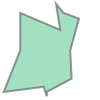

In [ ]:
node.polygon_cluster

In [ ]:
#| hide
node.scale(1.0,1.0)

In [ ]:
#| hide
node.get_density()

93.59053287028752

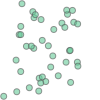

In [ ]:
#| hide
node.get_points()

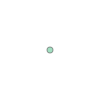

In [ ]:
#| hide
node.get_center()

<AxesSubplot:>

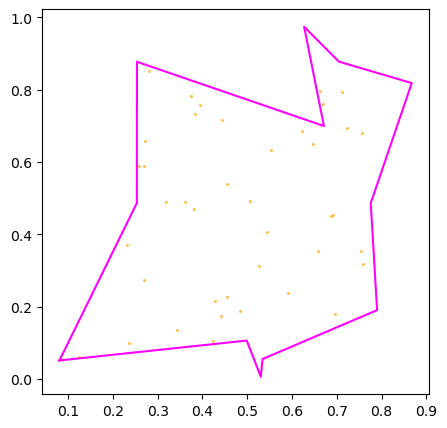

In [ ]:
#| hide
fig, axs = plt.subplots( figsize=(5,5))
node.viewer_cluster(axs, polygon=True)

In [ ]:
#|hide
node.tag_low_level()

[(<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.

In [ ]:
node.tag_low_level_noise_signal()

[(<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>

In [ ]:
node.tag_all_point()

[(<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.

In [ ]:
node.tag_all_point_noise_signal()

[(<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>, 'noise'),
 (<shapely.geometry.point.Point>

In [ ]:
#| hide 
bounds = node.polygon_cluster.bounds
x= [random.uniform (bounds[0], bounds[2]) for i in range(20)] 
y = [random.uniform (bounds[1], bounds[3]) for i in range(20)] 
points_check = [shapely.geometry.Point(i) for i in zip(x,y)]
node.check_point_children(points_check) ### No tiene hijos 

[]

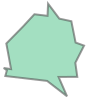

In [ ]:
#|hide
node= NodeCluster('Root')
node.populate_cluster (20, 34)
node.reproduce_node_polygon()

In [ ]:
#|hide
node2 = node.duplicate_node()


In [ ]:
#| hide 
#### Esta toda via no sirve 
####node.polygon_not_intersec_children()

### Methods (NodeCluster)

In the following section the documentation of most important methods of the NodeCluster class are shown 

#### Create cluster 

The following methos are par of the construction of the `NodeCluster` and some utilities that arte use in its construction. 


In [ ]:
show_doc(NodeCluster.__init__)

---

### NodeCluster.__init__

>      NodeCluster.__init__ (name, density=None, parent=None, children=None)

Constructor of the class

:param str name: Name of the cluster

:param double density: Density of the cluster (Default =None)

:param NodeCluster parent: Cluster parent (Default = None)

:param list children: List of its children (Default =None)

In [ ]:
show_doc(NodeCluster.populate_cluster)

---

### NodeCluster.populate_cluster

>      NodeCluster.populate_cluster (from_points_num=20, density=None,
>                                    num_points=None, min_scale_x=0.1,
>                                    max_scale_x=0.5, min_scale_y=0.1,
>                                    max_scale_y=0.5, random_state=170,
>                                    **kwargs)

Populate the cluster on random bases 

:param int random_state: Random state 

:param double min_scale_x: min x value range ( Default=.1 )

:param double max_scale_x: max x value range ( Default=.5 )

:param double min_scale_y: min y value range ( Default=.1 )

:param double max_scale_y: max y value range ( Default=.5 )

In [ ]:
show_doc(NodeCluster.create_polygon)

---

### NodeCluster.create_polygon

>      NodeCluster.create_polygon (from_points_num=20)

Generate a random polygon for the cluster

:param from_points_num: The number of points to 
generate the cluster from 

#### Random points
Generate random points inside cluster

In [ ]:
show_doc(NodeCluster.create_random_points)

---

### NodeCluster.create_random_points

>      NodeCluster.create_random_points (npoints_polygon=1000, random_state=120)

Create random points 

:param npoints_polygon Number of point to get

:random_state Random state integer to ste random

:returns: A shapely multyPoint clas witn npoints_polygon points

In [ ]:
show_doc(NodeCluster.polygon_not_intersec_children)

---

### NodeCluster.polygon_not_intersec_children

>      NodeCluster.polygon_not_intersec_children (**kwargs)

Returns a polygon that doesn't touch the any of children polygon's and 
it is inside the cluter's polygon 


:param int random_state: (Default= 123456)

:param int from_points_num: (Default= 20)

:param double max_scale_x: (Default= 0.5)

:param double max_scale_y: (Default= 0.5)

:returns tuple: Polygon, random points center  

#### scale
Scale the points inside the cluster

In [ ]:
show_doc(NodeCluster.scale)

---

### NodeCluster.scale

>      NodeCluster.scale (x_scale, y_scale, center_scale='center')

Scale the points in the cluster 

:param x_scale Scale factor to scale in x axis

:param y_scale Scale factor to scale in y axis

:param center_scale Scale center point  (Default = 'center')

:returns: No returns

#### Get values 
Extract values from the `NodeCluster` class

In [ ]:
show_doc(NodeCluster.get_density)

---

### NodeCluster.get_density

>      NodeCluster.get_density ()

Get the density of the cluster 

:returns double: The density of the node

In [ ]:
show_doc(NodeCluster.tag_low_level_noise_signal)

---

### NodeCluster.tag_low_level_noise_signal

>      NodeCluster.tag_low_level_noise_signal (point_check=None)

The tag the element of the node using the labels noise or signal
as a tag, if a set of point is pass (point_check != None)  
the elements are treated as part of the cluster and label it
accordingly.

:params list point_check: A list of shapely Points to tag (if None 
                    tags the points inside the cluster) 

:returns: A list of tuples (points , tag)

In [ ]:
show_doc(NodeCluster.get_center)

---

### NodeCluster.get_center

>      NodeCluster.get_center ()

Get the center of the bounding box poligon

:returns: Shapely Point center 

In [ ]:
show_doc(NodeCluster.get_points)

---

### NodeCluster.get_points

>      NodeCluster.get_points (all_tag=False)

Returns the noise point of the cluster, if all_tag is set true returns  
all the points of the its decendents

In [ ]:
show_doc(NodeCluster.get_point_decendent)

---

### NodeCluster.get_point_decendent

>      NodeCluster.get_point_decendent ()

Returns all the point of the node and its decendents

#### Vizualization 

Tools to visualize the cluster and its points

In [ ]:
show_doc(NodeCluster.viewer_cluster)

---

### NodeCluster.viewer_cluster

>      NodeCluster.viewer_cluster (ax, **kwargs)

Vizualization of the cluster 

:param ax: ax of a matplotlib figure

:param int level: Level to view 0 only the points of the cluster,
1 the children points, -1 all decendent points  (Default = 0 )

:param bool polygon: To draw the polygon of the cluster 
(Default = False).

:param bool polygon_children: Draw the poligon of its children 
(Default = False).

:param double size_cluster: Point size inside the cluster (noise)
(Default = 2)

:param str color_cluster : matplotlib color 

:param double alpha_cluster : alpha channel (Default = 0.5) 

:param double size_children : Point size children (Default = 1)

:param str color_children: matplotlib color

:param double alpha_children : alpha channel (Default = 0.5) 

:param bool polygon_color_children: Plot the children polygon 

:returns : Draw into the ax.

## Tree Cluster class 

The class for a hierarchical structure (clusters tree) that allows to visualize and create random hierargical geographical points

In [ ]:
#| export
class TreeClusters(object):
    levels = 0
    levels_nodes=[]
    root = None
    def __init__(self, 
                levels=None, 
                r_name = 'Root',
                level_str= 'l_',
                node_str ='n_',
                **kwargs
                ):
        """
        Build the tree 
        
        :param int levels: Number of leevels in the tree (Default =None) 
        
        :param str r_name : String to root label (Default= 'Root')
        
        :param str level_str: String to name the levels (Default= 'l_')
        
        :param str node_str: String to name the nodes (Default ='n_')
        
        :param double random_seed:
        """
        random_seed = kwargs.get('random_seed', 123)
        random.seed(random_seed)
        if levels is None:
            self.levels = 0
            self.levels_nodes=[]
            self.root = None
            return 
        
        self.levels = levels 
        self.root = NodeCluster(name=r_name)
        levels_nodes = []
        previus_level= []

        for level in range(self.levels):
            if level==0:
                previus_level = [self.root]
                levels_nodes.append(previus_level)
            next_level= []
            for prev in  previus_level:
                n_childs = random.randint(0, 5)
                node_childs = [
                    NodeCluster(name = prev.name +'_'+level_str+str(level)+'_'+node_str+str(i),
                                parent=prev) for i in  range(n_childs) 
                            ]
                next_level = next_level +node_childs
                
            previus_level = next_level
            levels_nodes.append(next_level)     
        self.levels_nodes=levels_nodes
    
    def get_level(self, level):
        """
        Get the level
        
        :param int level: Level to get nodes
        
        :returns List: All the nodes in the level
        """
        if level > len(self.levels_nodes)-1:
            raise ValueError('There is no level : ', level, ' in the tree')

            
        return self.levels_nodes[level]
    
    def get_node(self, level_int, node_int):
        """
        Get the node in level_in at position node_int
        
        :param  int level_int: Level of node
        
        :param int node_int: Position in level
        
        :returns NodeCluster: Node 
        """
        return self.levels_nodes[level_int][node_int]
    ######Populate the structure 
    def populate_tree(self, 
                    number_per_cluster= None,
                    density_init= None,
                    factor_density = 3, 
                    density_init_list = None, # list of densities by level
                    **kwargs
                    ):
        """
        Populate the TreeCluster structure, populate each node 
        inside the TreeClusters using random ranges.
        
        :param int number_per_cluster: Number of point per cluster (Default= None)
        
        :param double density_init: Initial density of the tree (Default= None)
        
        :param double factor_density: Factor to increase density (Default = 3)         
        
        :returns None:
        """
        verbose = kwargs.get('verbose', False)
        if verbose:
            print("Entro a la funcion populate_tree" )
        for level_id, level in  enumerate(self.levels_nodes):
            rand_cluster_state= np.random.randint(0, 1500, len(level)) ## Random ints for random_seed
            if level_id ==0 :
                density_lev= density_init
            elif density_init is not None:
                density_lev= prev_density*3
            
            for clust_id, cluster in enumerate(level): 
                if number_per_cluster is not None:
                    cluster.populate_cluster(num_points =number_per_cluster,
                                random_state = rand_cluster_state[clust_id],
                                **kwargs
                    )
                elif number_per_cluster is None and density_lev is not None:
                    cluster.populate_cluster(
                                density= density_lev,
                                random_state = rand_cluster_state[clust_id],
                                **kwargs
                    )
                elif number_per_cluster is None and density_lev is None and density_init_list is not None:
                    cluster.populate_cluster(
                                density= density_init_list[level_id],
                                random_state = rand_cluster_state[clust_id],
                                **kwargs
                    )
    ########Get all point in the tree
    def get_points_tree(self, level= None, iterative =False):
        """
        Return all the points in the tree
        
        :param int level: The level to exctract the points (default = None)
        
        :param bool iterative: To exctract iterative (Default =False)
        
        :return Points :
        """
        
        if level != None:
            lis_level = self.get_level(level)
            all_points = []
            for node in lis_level:
                all_points = all_points + [i for i in node.append(node.get_points(all_tag = iterative ) )]
            return all_points
        else:
            all_points = []
            for level_t in  self.levels_nodes:
                for node in level_t:

                    all_points =all_points+[i for i in node.get_points(all_tag = iterative )] 
            return all_points
            #return self.root.get_points( all_tag = iterative )
    ####### visualize the structure 
    def print_structure(self):
        """
        Print the tree structure in console
        
        """
        print(self.root.name)
        for pre, _, node in RenderTree( self.root ):
            treestr = u"%s%s" % (pre, node.name)
            print(treestr.ljust(8))
    
    #### visualization of the clusters
    
    def visualize(self,
                    axs,
                    colors_levels= None,
                    **kwargs
                    ):
        """
        Visualize the tree 
        
        :param axs: The ax to plot the figure
        
        :param str color_map_val: use a matplotlib colormap
        """
        if colors_levels is None:
            color_map_val= kwargs.get('color_map_val', 'jet')
            colors=  cm.get_cmap(color_map_val, len(self.levels_nodes))
            color_map= colors#matplotlib.colors.ListedColormap(colors)
        else:
            color_map= matplotlib.colors.ListedColormap(colors_levels)
        
        for level, level_clusters in enumerate(self.levels_nodes):
            for cluster in level_clusters:
                cluster_alpha= kwargs.get('cluster_alpha', .2)
                cluster.viewer_cluster(
                    axs,
                    color_cluster= color_map(level),
                    polygon_color = color_map(level),
                    **kwargs
                )
    ##### Vizulize levels
    def visualize_levels(self,
                        axs,
                        **kwargs
                        ):
        """
        Visualize a specific level
        
        :param axe matplolib  axs: where thte plot will be draw
        
        :param list int levels: list of levels to  visualizelevel 
        
        :returns None:
        
        """
        levels_vis = kwargs.get('levels', [0]),
        # print(levels_vis)
        color_map_val= kwargs.get('color_map_val', 'jet')
        colors=  cm.get_cmap(color_map_val, len(levels_vis)+1)
        color_map= colors#matplotlib.colors.ListedColormap(colors)
        
        # print([ lev_i for lev_i in levels_vis[0] ])
        for level, level_clusters in enumerate([ self.levels_nodes[lev_i] for lev_i in levels_vis[0] ]):
            for cluster in level_clusters:
                cluster_alpha= kwargs.get('cluster_alpha', .2)
                cluster.viewer_cluster(
                    axs,
                    color_cluster= color_map(level),
                    polygon_color = color_map(level),
                    **kwargs
                )
    #########################Copy
    def copy_dynamic(self, 
                    list_levels_node = None,
                    **kwargs 
                    ):
        """
        creates a dynamic copy of the tree
        """
        # duplicate_node
        #### Es necesario duplicar la estructura 
        new_tree = TreeClusters()
        #new_tree.levels = self.levels
        verbose = kwargs.get('verbose', False )
        # print (kwargs.get('copy_pref', False ))
        
        for level_id ,level_tree in enumerate(self.levels_nodes):
            level_li =[]
            for node in level_tree:
                new_node = node.duplicate_node(**kwargs)
                ####Copy the relation to the parent 
                ### ToDo change if the node is not include on the dinamic copy
                
                if node.parent in self.levels_nodes[level_id-1] and level_id!=0 :
                    result_index = self.levels_nodes[level_id-1].index(node.parent)
                    if verbose:
                        print(f"The {node.name} parent has an index of {result}.")
                    new_node.parent =  new_tree.levels_nodes[level_id-1][result_index]
                else : 
                    new_node.parent =  None

                level_li.append(new_node) 
            new_tree.levels_nodes.append(level_li)
        new_tree.root = new_tree.levels_nodes[0][0]
        return new_tree
    
    def get_deepth(self):
        """
        Returns the deepth of the tree
        """
        return len(self.levels_nodes)



    def size(self):
        """ 
        Returns the number of node in the tree
        """
        sum_s=0
        for i in self.levels_nodes:
            sum_s +=len(i)
        return sum_s

    def size_points(self):
        """
        Returns the number of points in the tree 
        
        """
        sum_s=0
        for level in self.levels_nodes:
            for node in level:
                sum_s += len(node.point_cluster_noise)
        return sum_s
    
    def get_dataframe(self, **kwargs):
        """
        Get a pandas Dataframe with the points and the tags of for each point
        :returns pandas.DataFrame : Returns a dataframe with the columns 'Tag ',
                                    'Final_tag', 'level', and 'cluster_id'
    
        Tag: is the reference of the point belong to a cluster as noise
        
        Final_tag: The point can belong to a inner cluster this tag tell 
                     wich is the last tag category the point belong to.
        
        level: list of levels of the clusters that the point belongs to.
        
        cluster_id: list of cluster id that the points belongs to.  
        
        """
        points_tags = self.root.tag_all_point()
        df_points_tag= pd.DataFrame(points_tags, columns= ['Points', 'Tag'])
        df_points_tag['Final_tag']= df_points_tag['Tag'].apply(lambda l :retag_from_strings(l) )
        levels_id = df_points_tag['Final_tag'].apply(lambda l: levels_from_strings(l,level_str='_l_', node_str='_n_'))
        df_points_tag['level'] = levels_id.apply(lambda l: l[0])
        df_points_tag['cluster_id'] = levels_id.apply(lambda l: l[1])
        return df_points_tag
    

    def get_dataframe_recursive(self,  **kwargs):
        """
        Returns a dataframe with the columns 'Tag ', 'Final_tag', 'level', and 'cluster_id'
        
        This function is with the purpouse to obtain the same tags for the 'level' and 
        'cluster_id' from the recorsive clustering function
        
        Tag: is the reference of the point belong to a cluster as noise
        Final_tag: the point can belong to a inner cluster this tag tell 
                    wich is the las tag category the point belong to.
        level: list of levels of the clusters that the point belongs to.
        cluster_id: list of cluster id that the points belongs to.  
        """
        ### Pedir que como parametros level_str='_l_', node_str
        func_level_nodes = kwargs.get('func_level_nodes' , string_recursive_tag) 
        

        points_tags = self.root.tag_all_point()
        df_points_tag= pd.DataFrame(points_tags, columns= ['Points', 'Tag'])
        df_points_tag['Final_tag']= df_points_tag['Tag'].apply(lambda l :retag_from_strings(l) )
        levels_id = df_points_tag['Final_tag'].apply(lambda l: func_level_nodes( l,tree_rec= self,**kwargs))
        df_points_tag['level'] = levels_id.apply(lambda l: l[0])
        df_points_tag['cluster_id'] = levels_id.apply(lambda l: l[1])
        return df_points_tag
    
    def get_labels_point_nodes(self, **kwargs):
        """The function returns the points of the tree labeled for each
        node
        """
        all_points=[] 
        level_get = kwargs.get('level_get' , self.get_deepth())
        for num_lev, level in enumerate( self.levels_nodes):
            if num_lev < level_get:
                all_level = []
                for node in level:
                    all_level.append([(i,node.name + '_noise')  for i in node.point_cluster_noise])
                all_points.append(all_level)
            elif num_lev == level_get:
                all_level = []
                for node in level:
                    all_level.append([(i,node.name + '_noise')  for i in node.get_point_decendent()])
                all_points.append(all_level)

        applaztalista = []
        for level_p in all_points:
            for node_res in level_p:
                applaztalista =applaztalista +node_res  
        return applaztalista


    def get_dataframe_recursive_node_label(self,  **kwargs):
        """
        Returns a dataframe with the columns 'Tag ', 'Final_tag', 'level', and 'cluster_id'
        This function is with the purpouse to obtain the same tags for the 'level' and 
        'cluster_id' from the recursive clustering function
        Tag: is the reference of the point belong to a cluster as noise
        Final_tag: the point can belong to a inner cluster this tag tell 
        wich is the las tag category the point belong to.
        level: list of levels of the clusters that the point belongs to.
        cluster_id: list of cluster id that the points belongs to.  
        """
        ### Pedir que como parametros level_str='_l_', node_str
        func_level_nodes = kwargs.get('func_level_nodes' , string_recursive_tag) 
        

        points_tags = self.get_labels_point_nodes(**kwargs)
        df_points_tag= pd.DataFrame(points_tags, columns= ['Points', 'Tag'])
        df_points_tag['Final_tag']= df_points_tag['Tag'].apply(lambda l :retag_from_strings(l) )
        if func_level_nodes == string_recursive_tag:
            levels_id = df_points_tag['Final_tag'].apply(lambda l: func_level_nodes( l,tree_rec= self,**kwargs))
        else:
            levels_id = df_points_tag['Final_tag'].apply(lambda l: func_level_nodes( l,**kwargs))
        df_points_tag['level'] = levels_id.apply(lambda l: l[0])
        df_points_tag['cluster_id'] = levels_id.apply(lambda l: l[1])
        return df_points_tag

    ########################Noise signal tree 
    def get_tag_noise_signal_tree(self):
        
        """
        Get the tags for each point in the cluster node 
        Returns all noise level tags 
        :returns: A dataframe with the tags of the all the points. 
        """
        ### tag for each level 
        all_point_tag_levels= []
        for num,  level in enumerate(self.levels_nodes):
            for node in level:
                all_point_tag_levels = all_point_tag_levels+ [ (i[0],'1_'*num +i[1]) for i in node.tag_low_level_noise_signal()]
        #### Names a
        df_tags= pd.DataFrame(zip([i[0] for i in all_point_tag_levels],
                                  [i[1] for i in all_point_tag_levels] ),
                              columns= ['Points', 'Final_tag']) 

        df_tags['concat_tags'] =  df_tags['Final_tag'].apply(lambda l:
                                                        '_'.join(l.split('_')+['noise']*(len(self.levels_nodes)-len(l.split('_'))))
                                                    )
        df_tags['concat_tags_signal'] = df_tags['concat_tags']
        
        return df_tags
    


In [ ]:
#| hide 
tree = TreeClusters(3, random_seed= 1)

In [ ]:
#| hide
tree.populate_tree(number_per_cluster=100)

In [ ]:
#| hide
tree.print_structure()

Root
Root    
└── Root_l_0_n_0
    ├── Root_l_0_n_0_l_1_n_0
    ├── Root_l_0_n_0_l_1_n_1
    │   ├── Root_l_0_n_0_l_1_n_1_l_2_n_0
    │   └── Root_l_0_n_0_l_1_n_1_l_2_n_1
    ├── Root_l_0_n_0_l_1_n_2
    └── Root_l_0_n_0_l_1_n_3
        ├── Root_l_0_n_0_l_1_n_3_l_2_n_0
        ├── Root_l_0_n_0_l_1_n_3_l_2_n_1
        └── Root_l_0_n_0_l_1_n_3_l_2_n_2


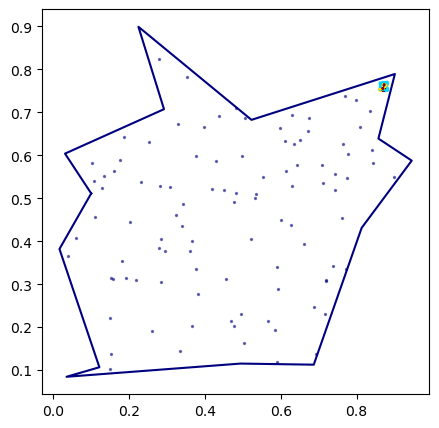

In [ ]:
#| hide
fig, axs = plt.subplots( figsize=(5,5))
tree.visualize(axs, polygon=True)

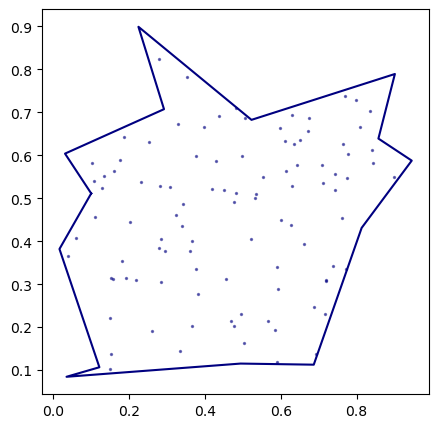

In [ ]:
#| hide
fig, axs = plt.subplots( figsize=(5,5))

tree.visualize_levels(axs,polygon= True)

In [ ]:
#| hide
tree.get_deepth()

4

In [ ]:
#| hide 
tree.size()

11

In [ ]:
#| hide 
tree.size_points()

1100

In [ ]:
#| hide 
##tree.get_dataframe()

In [ ]:
#| hide 
tree.get_dataframe_recursive()

,Points,Tag,Final_tag,level,cluster_id
0,POINT (0.1332887723486744 0.5531487377697328),Root_noise,Root_noise,[],[]
1,POINT (0.5220208201391647 0.4049034973194526),Root_noise,Root_noise,[],[]
2,POINT (0.0400592971320845 0.3654938946569972),Root_noise,Root_noise,[],[]
3,POINT (0.5894355099586788 0.118528520977431),Root_noise,Root_noise,[],[]
4,POINT (0.7742775025067661 0.5474622686585349),Root_noise,Root_noise,[],[]
...,...,...,...,...,...
1090,POINT (0.8694051315138658 0.7566720152763152),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1091,POINT (0.8694648552843214 0.7566760941390871),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1092,POINT (0.8695646825665192 0.7565715826525815),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1093,POINT (0.8694369115386821 0.7565849683337992),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]


In [ ]:
#| hide
tree.get_labels_point_nodes()

[(<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.point.Point>, 'Root_noise'),
 (<shapely.geometry.

In [ ]:
#| hide
tree.get_dataframe_recursive_node_label()

,Points,Tag,Final_tag,level,cluster_id
0,POINT (0.1332887723486744 0.5531487377697328),Root_noise,Root_noise,[],[]
1,POINT (0.5220208201391647 0.4049034973194526),Root_noise,Root_noise,[],[]
2,POINT (0.0400592971320845 0.3654938946569972),Root_noise,Root_noise,[],[]
3,POINT (0.5894355099586788 0.118528520977431),Root_noise,Root_noise,[],[]
4,POINT (0.7742775025067661 0.5474622686585349),Root_noise,Root_noise,[],[]
...,...,...,...,...,...
1095,POINT (0.8694947534962281 0.756619974134029),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1096,POINT (0.8694051315138658 0.7566720152763152),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1097,POINT (0.8694648552843214 0.7566760941390871),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]
1098,POINT (0.8695646825665192 0.7565715826525815),Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,Root_l_0_n_0_l_1_n_3_l_2_n_2_noise,[],[]


In [ ]:
#| hide 
tree.get_tag_noise_signal_tree()

,Points,Final_tag,concat_tags,concat_tags_signal
0,POINT (0.1332887723486744 0.5531487377697328),noise,noise_noise_noise_noise,noise_noise_noise_noise
1,POINT (0.5220208201391647 0.4049034973194526),noise,noise_noise_noise_noise,noise_noise_noise_noise
2,POINT (0.0400592971320845 0.3654938946569972),noise,noise_noise_noise_noise,noise_noise_noise_noise
3,POINT (0.5894355099586788 0.118528520977431),noise,noise_noise_noise_noise,noise_noise_noise_noise
4,POINT (0.7742775025067661 0.5474622686585349),noise,noise_noise_noise_noise,noise_noise_noise_noise
...,...,...,...,...
1095,POINT (0.8694947534962281 0.756619974134029),1_1_1_noise,1_1_1_noise,1_1_1_noise
1096,POINT (0.8694051315138658 0.7566720152763152),1_1_1_noise,1_1_1_noise,1_1_1_noise
1097,POINT (0.8694648552843214 0.7566760941390871),1_1_1_noise,1_1_1_noise,1_1_1_noise
1098,POINT (0.8695646825665192 0.7565715826525815),1_1_1_noise,1_1_1_noise,1_1_1_noise


### Methods
The following are the mos important methos inside the `TreeClusters` class

#### Counstruct tree 

The tree clustes structure 

In [ ]:
show_doc(TreeClusters.__init__)

---

### TreeClusters.__init__

>      TreeClusters.__init__ (levels=None, r_name='Root', level_str='l_',
>                             node_str='n_', **kwargs)

Build the tree 

:param int levels: Number of leevels in the tree (Default =None) 

:param str r_name : String to root label (Default= 'Root')

:param str level_str: String to name the levels (Default= 'l_')

:param str node_str: String to name the nodes (Default ='n_')

:param double random_seed:

In [ ]:
show_doc(TreeClusters.populate_tree)

---

### TreeClusters.populate_tree

>      TreeClusters.populate_tree (number_per_cluster=None, density_init=None,
>                                  factor_density=3, density_init_list=None,
>                                  **kwargs)

Populate the TreeCluster structure, populate each node 
inside the TreeClusters using random ranges.

:param int number_per_cluster: Number of point per cluster (Default= None)

:param double density_init: Initial density of the tree (Default= None)

:param double factor_density: Factor to increase density (Default = 3)         

:returns None:

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| number_per_cluster | NoneType | None |  |
| density_init | NoneType | None |  |
| factor_density | int | 3 |  |
| density_init_list | NoneType | None | list of densities by level |
| kwargs |  |  |  |

#### Tree Values 

In [ ]:
show_doc(TreeClusters.get_deepth)

---

### TreeClusters.get_deepth

>      TreeClusters.get_deepth ()

Returns the deepth of the tree

In [ ]:
show_doc(TreeClusters.size)

---

### TreeClusters.size

>      TreeClusters.size ()

Returns the number of node in the tree

#### Points 

In [ ]:
show_doc(TreeClusters.get_points_tree)


---

### TreeClusters.get_points_tree

>      TreeClusters.get_points_tree (level=None, iterative=False)

Return all the points in the tree

:param int level: The level to exctract the points (default = None)

:param bool iterative: To exctract iterative (Default =False)

:return Points :

#### Visualize


In [ ]:
show_doc(TreeClusters.print_structure)

---

### TreeClusters.print_structure

>      TreeClusters.print_structure ()

Print the tree structure in console

In [ ]:
show_doc(TreeClusters.visualize)

---

### TreeClusters.visualize

>      TreeClusters.visualize (axs, colors_levels=None, **kwargs)

Visualize the tree 

:param axs: The ax to plot the figure

:param str color_map_val: use a matplotlib colormap

In [ ]:
show_doc(TreeClusters.visualize_levels)

---

### TreeClusters.visualize_levels

>      TreeClusters.visualize_levels (axs, **kwargs)

Visualize a specific level

:param axe matplolib  axs: where thte plot will be draw

:param list int levels: list of levels to  visualizelevel 

:returns None:

## Helper functions

Functions to help build the nodes and trees  

In [ ]:
show_doc(inside_polygon)

---

### inside_polygon

>      inside_polygon (list_points, poligon_check, min_percent)

Help function to validate the number of points that are inside the polygon 

:param list list_points: List of points to consider 

:param shapely.geometry.Polygon poligon_check:   

:param min_percent: Minimun percent of point to be consider inside 

:returns tuple: (bool, list of point inside).   

In [ ]:
show_doc(poligon_non_convex_from_Points)

---

### poligon_non_convex_from_Points

>      poligon_non_convex_from_Points (points_li)

Create a random (no convex) poligon from the points
The algorithm returns a polygon creatated from the points, the 
non convex part it is not always guaranteed.

:param list points_li: list of shapely.geometry.Point 

:returns shapely.grometry.Polygon: The polygon created 

In [ ]:
show_doc(poligon_non_convex_random_gen)

---

### poligon_non_convex_random_gen

>      poligon_non_convex_random_gen (npoints)

Create a random (no convex) poligon from n points
The algorithm returns a polygon creatated from n random 2d points the 
non convex part it is not always guaranteed.

:param int npoints: Number of point to generate the polygon 

:returns shapely.geometry.Polygon: The polygon created

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()